In [1]:
import datajoint as dj
import numpy as np
import torch
from torch.autograd import Variable
from torch.nn.init import normal, constant
from torch import nn
from matplotlib import pyplot as plt
from attorch.train import early_stopping
from torch.utils.data import TensorDataset, DataLoader
import seaborn as sns
sns.set_context('notebook', font_scale=1.3)
from v1_likelihood.train import CVSet, CleanContrastSessionDataSet, binnify
from v1_likelihood.models import Net
from v1_likelihood.utils import set_seed

%matplotlib inline

from numpy.linalg import inv

/usr/local/lib/python3.5/dist-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


Connecting eywalker@10.28.0.34:3306


/usr/local/lib/python3.5/dist-packages/pymysql/cursors.py:165: Warning: (1681, "'ERROR_FOR_DIVISION_BY_ZERO' is deprecated and will be removed in a future release.")
  result = self._query(query)
/usr/local/lib/python3.5/dist-packages/pymysql/cursors.py:165: Warning: (1681, "'NO_ZERO_DATE' is deprecated and will be removed in a future release.")
  result = self._query(query)
/usr/local/lib/python3.5/dist-packages/pymysql/cursors.py:165: Warning: (1681, "'NO_ZERO_IN_DATE' is deprecated and will be removed in a future release.")
  result = self._query(query)


In [2]:
key = {'csc_hash': 'b047337460082b62b44a8bc4ccfb4c400b6c9e95', 'dataset_contrast': '0.9'}

In [35]:
keys = CVSet().fetch('KEY')
key = keys[30]

In [36]:
train_set, valid_set = (CVSet() & key).fetch_datasets()

Prepare the data

In [38]:
print('Working!')

train_set, test_set = (CVSet() & key).fetch_datasets()
#bin_width, bin_counts, clip_outside = (BinConfig() & key).fetch1('bin_width', 'bin_counts', 'clip_outside')
bin_counts = 61
bin_width = 1.0
clip_outside = True
delta = bin_width
nbins = bin_counts

train_counts, train_ori = np.concatenate(train_set['counts'], 1).T, train_set['orientation']
valid_counts, valid_ori = np.concatenate(test_set['counts'], 1).T, test_set['orientation']

xv, train_bins = binnify(train_ori, delta=bin_width, nbins=bin_counts, clip=clip_outside)
_, valid_bins = binnify(valid_ori, delta=bin_width, nbins=bin_counts, clip=clip_outside)

good_pos = train_bins >= 0
train_counts = train_counts[good_pos]
train_ori = train_bins[good_pos]

good_pos = valid_bins >= 0
valid_counts = valid_counts[good_pos]
valid_ori = valid_bins[good_pos]

Working!


In [39]:
sigmaA = 3
sigmaB = 15
pv = (np.arange(nbins) - nbins//2) * delta
prior = np.log(np.exp(- pv**2 / 2 / sigmaA**2) / sigmaA + np.exp(- pv**2 / 2 / sigmaB**2) / sigmaB)
prior = Variable(torch.from_numpy(prior)).cuda().float()

In [40]:
train_x = torch.Tensor(train_counts)
train_t = torch.Tensor(train_ori).type(torch.LongTensor)

valid_x = Variable(torch.Tensor(valid_counts)).cuda()
valid_t = Variable(torch.Tensor(valid_ori).type(torch.LongTensor)).cuda()

train_dataset = TensorDataset(train_x, train_t)
valid_dataset = TensorDataset(valid_x, valid_t)

In [41]:
def objective(net, x=None, t=None):
    if x is None and t is None:
        x = valid_x
        t = valid_t
    net.eval()
    y = net(x)
    posterior = y + prior
    _, loc = torch.max(posterior, dim=1)
    v =(t.double() - loc.double()).pow(2).mean().sqrt() * delta
    return v.data.cpu().numpy()[0]

## Try linear regression

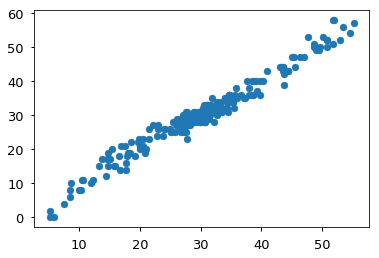

In [42]:
def extend_ones(x):
    return np.concatenate([x, np.ones([x.shape[0], 1])], axis=1)

tc = extend_ones(train_counts)

w = inv(tc.T @ tc + np.diag(np.ones(tc.shape[1]) * 0.0001)) @ tc.T @ train_ori

t_hat = extend_ones(valid_counts) @ w

plt.scatter(t_hat, valid_ori)

In [43]:
np.sqrt(np.mean((t_hat - valid_ori)**2)) * delta

2.039669657405666

## Fit NN

In [44]:
net = Net(n_output=61, n_hidden=[600, 600], std=0.001, dropout=0.5)
net.cuda()
loss = nn.CrossEntropyLoss().cuda()

10.601097108879546


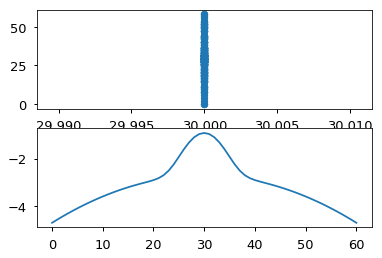

In [46]:
net.eval()
y = net(valid_x)

y = y + prior
val, idx = torch.max(y, 1)
yd = y.data.cpu().numpy()

plt.subplot(211)
t_hat = idx.data.cpu().numpy()
plt.scatter(t_hat, valid_ori)

print(np.sqrt(np.mean((t_hat - valid_ori)**2)) * delta)

plt.subplot(212)

plt.plot(yd[47])

In [51]:
net.std = 1e-2

set_seed(8)
net.initialize()

alpha = 30 #3e-2 #7e-3 #1e-3


#scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=3000, gamma=0.3)
learning_rates = 0.03 * 3.0**(-np.arange(3))

for lr in learning_rates:
    print('\n\n\n\n LEARNING RATE: {}'.format(lr))
    optimizer = torch.optim.SGD(net.parameters(), lr=lr)
    for epoch, valid_score in early_stopping(net, objective, interval=20, start=100, patience=20, max_iter=300000, maximize=False):
        data_loader = DataLoader(train_dataset, shuffle=True, batch_size=128)
        for x_, t_ in data_loader:
            x, t = Variable(x_).cuda(), Variable(t_).cuda()
            net.train()
            optimizer.zero_grad()
            y = net(x)
            post = y + prior
            val, _ = post.max(1, keepdim=True)
            post = post - val
            #sparcity = y.abs().sum(1).mean()
            conv_filter = Variable(torch.from_numpy(np.array([-0.25, 0.5, -0.25])[None, None, :]).type(y.data.type()))
            smoothness = nn.functional.conv1d(y.unsqueeze(1), conv_filter).pow(2).mean()
            score = loss(post, t)
            score = score + alpha * smoothness
            score.backward()
            optimizer.step()
        if epoch % 10 == 0:
            print('Score: {}'.format(score.data.cpu().numpy()[0]))
        #scheduler.step()

Setting numpy and torch seed to 8




 LEARNING RATE: 0.03
Score: 3.326781749725342
Score: 3.163904905319214
[120|00/20] ---> 5.049970558644061
Score: 2.942518949508667
Score: 2.8069908618927
[140|01/20] -/-> 6.160839807734322
Score: 2.967233657836914
Score: 2.7527925968170166
[160|01/20] ---> 4.569097501955814
Score: 2.6931567192077637
Score: 2.4466190338134766
[180|00/20] ---> 3.631118564083486
Score: 2.205421209335327
Score: 2.493480682373047
[200|01/20] -/-> 4.567168798829797
Score: 2.3107972145080566
Score: 2.42386531829834
[220|01/20] ---> 2.5177781968350885
Score: 2.2994582653045654
Score: 2.2095327377319336
[240|01/20] -/-> 2.587669848008194
Score: 2.051297664642334
Score: 2.0491631031036377
[260|01/20] ---> 2.3447382277832625
Score: 2.185835599899292
Score: 2.2809841632843018
[280|01/20] -/-> 3.2468215565787286
Score: 2.3659932613372803
Score: 2.2043991088867188
[300|02/20] -/-> 3.1927781944756113
Score: 1.9769006967544556
Score: 2.149103879928589
[320|03/20] -/-> 2.4638353397

In [52]:
objective(net, Variable(train_x).cuda(), Variable(train_t).cuda())

0.8644516692407732

In [53]:
objective(net, valid_x, valid_t)

1.6712125962456783

Text(0.5,0.98,'$\\mathbf{E}[\\sigma]$=1.867')

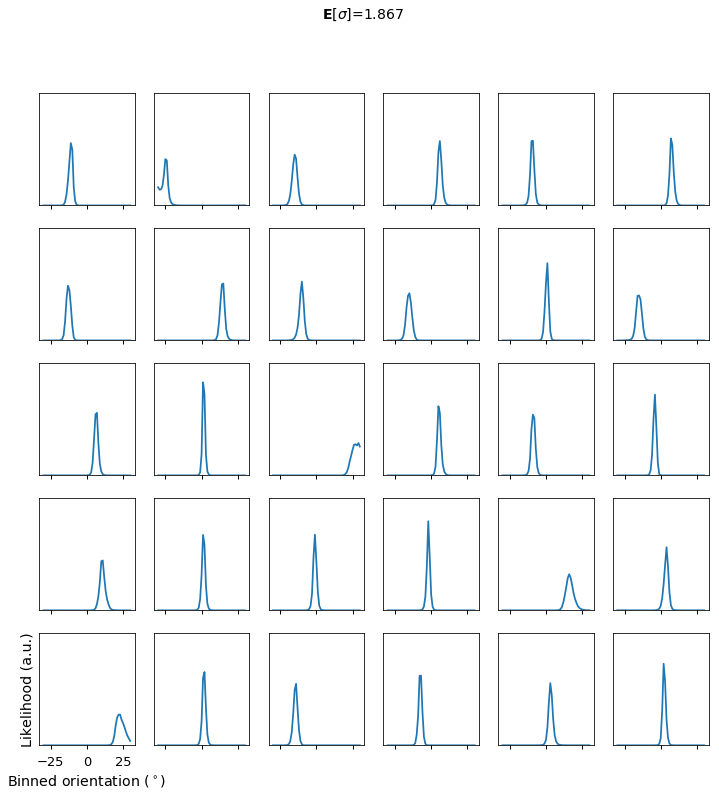

In [54]:
from itertools import count

y = net(valid_x)
#val, idx = torch.max(y, 1)
yd = y.data.cpu().numpy()
yd = np.exp(yd)
yd = yd / yd.sum(axis=1, keepdims=True)

loc = yd.argmax(axis=1)
ds = (np.arange(nbins) - loc[:, None])**2

avg_sigma = np.mean(np.sqrt(np.sum(yd * ds, axis=1))) * delta


n_rows = 5
n_cols = 6
fig, axs = plt.subplots(5, 6, figsize=(12, 12))

for c, ((i, j), ax) in zip(count(), np.ndenumerate(axs)):
    
    ax.plot(pv, yd[c])
    ax.set_ylim([0, 0.5])
    ax.set_yticks([])
    if j == 0 and i == n_rows-1:
        ax.set_ylabel('Likelihood (a.u.)')
        ax.set_xlabel('Binned orientation ($^\circ$)')
    else:
        ax.set_xticklabels([])

fig.suptitle("$\mathbf{{E}}[\sigma]$={:0.3f}".format(avg_sigma), fontsize=14)
